# Fourier Features Networks for Single Image _ paper ver

Demo code for training Fourier features networks that reconstruct single image.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


### A. Load single image as tensor

Set image directory path and image number

and load image as PIL Image

image size : (2040, 1356)


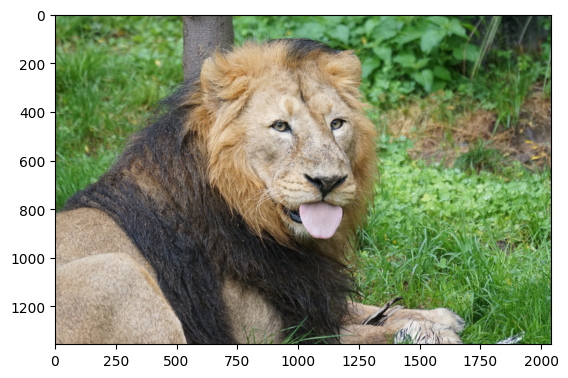

In [3]:
IMG_DIR = "DIV2K_valid_HR"      # directory path that contains images
IMG_NUM = "0809"                # image number
RECON_SIZE = 512

img = Image.open(f"{IMG_DIR}/{IMG_NUM}.png")        # read image as PIL Image

print(f'image size : {img.size}')
plt.imshow(img)


In [4]:
# Define a function that transforms loaded image

transform_funcs = transforms.Compose([
    transforms.ToTensor(),          # change PIL image or numpy array in the range [0, 255] to tensor in the range [0.0, 1.0]
    transforms.CenterCrop(RECON_SIZE),
])

img_tensor = transform_funcs(img).to(device)

shape of tensor : torch.Size([3, 512, 512])


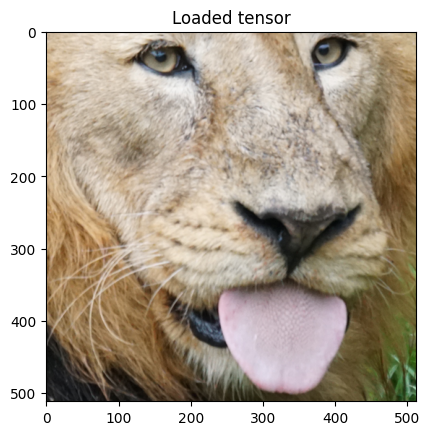

In [5]:
# Define a function that shows the recieved tensor by plt.imshow()

def tensor_img_show(tensor, plt_title = None):
    numpy_img = transforms.ToPILImage()(tensor)

    if plt_title is not None: plt.title(plt_title)  # show title when function receives title string
    plt.imshow(numpy_img)
    plt.show()



print(f'shape of tensor : {img_tensor.shape}')
tensor_img_show(img_tensor, plt_title = 'Loaded tensor')

### B. Define util functions

  - PSNR(img1: tensor, img2: tensor)
  
      return psnr_result(float)

In [6]:
def PSNR(img1, img2):
    max_val = torch.max(img1)
    mse = torch.mean((img1 - img2)**2)
    psnr_torch = 20 * torch.log10(max_val/torch.sqrt(mse))
    return psnr_torch.detach().item()

### C. Define mapping module and reconstruction network

#### C.1. Gaussian Fourier Features Mapping

This block contains the part that defines a Gaussian Fourier Features Mapping Module.

  - **CLASS GaussianFourierFeaturesMappingModule**(scale, mapping_size)
    
    At initialization, set self.B as the returned value by make_gaussian_vec() function.

    When doing forward by this module, get the coordinate tensor 'x' and return fourier mapped input
  
  - **make_gaussian_vec**(scale, mapping_size)

    -> return None (when scale argument is None)

    -> return gaussian_vec(tensor) (shape : [2, GAUSSIAN_VEC_LEN])
  
  - **input_mapping**(x: tensor, gassian_vec: None or tensor)

    -> return None (when gaussian_vec argument is None)

    -> return fourier mapped input tensor (shape : [batches, 2*GAUSSIAN_VEC_LEN, width, height])

In [7]:
GAUSSIAN_SCALE = 10.0
GAUSSIAN_VEC_LEN = 128

In [8]:
# Get scale, mapping_size as argument, and return gaussian vector
def make_gaussian_vec(scale=None, mapping_size = GAUSSIAN_VEC_LEN):
    if scale is None:
        return None
    else:
        gaussian_vec = torch.randn((2, mapping_size)) * float(scale)
    return gaussian_vec



# Get coordinate input tensor 'x' and 'gaussian vector' returned by make_gaussian_vec function
# (x : 4-dim tensor of which shape is [batches, channels, width, height])
def input_mapping(x, gassian_vec = None):
    if gassian_vec is None:
        return x
    else:
        assert x.dim() == 4, f'Expected 4-dim input, but got {x.dim()}-dim input'

        batches, channels, width, height = x.shape

        '''
        In input_mapping, we have to get matrix multiplication of 'x' and 'gassian_vec'.

        Since we want to get fourier mapped input with Gaussian distribution,

            1) reshape the shape of 'x' ([batches, channels, width, height] -> [batches * width * height, channels]),
            
            2) get matrix multiplication result of reshaped 'x' and 'gassian vec'
                ('x' shape : [[batches * width * height, 2], 'gaussian vec' shape : [2, GAUSSIAN_VEC_LEN]]),

            3) call veiw() and permute() function for the result of 2 to be tensor of which shape is [batches, GAUSSIAN_VEC_LEN, width, height]

            4) multiply 2*pi to all elements of the result tensor of 3

            5) return tensor shape : [batches, 2*GAUSSIAN_VEC_LEN, width, height]

        '''
        # reshape the shape of 'x' ([batches, channels, width, height] -> [batches * width * height, channels])
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        # get matrix multiplication result of reshaped 'x' and 'gassian vec'
        x = x @ gassian_vec.to(x.device)

        # get tensor of which shape is [batches, GAUSSIAN_VEC_LEN, width, height]
        x = x.view(batches, width, height, GAUSSIAN_VEC_LEN)
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim = 1)

In [9]:
class GaussianFourierFeaturesMapping(nn.Module):
    def __init__(self, scale = None, mapping_size = GAUSSIAN_VEC_LEN):
        super(GaussianFourierFeaturesMapping, self).__init__()
        self.B = make_gaussian_vec(scale = scale, mapping_size = mapping_size)

    def forward(self, x):
        output = input_mapping(x, gassian_vec = self.B)
        return output

#### C.2. Define reconstruction network

In [10]:
class ReconNet(nn.Module):
    def __init__(self, num_layers = 4, mapping_size = 2*GAUSSIAN_VEC_LEN):
        super(ReconNet, self).__init__()
        self.conv_block = self.make_conv_block(num_layers, mapping_size)
        self.last_layer = nn.Conv2d(mapping_size, 3, kernel_size = 1, padding = 0)
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.last_layer(x)          # num of output channel : 3 (RGB value)
        output = torch.sigmoid(x)       # to get output value in the range [0, 1]
        return output
    
    # Return a Sequential module that consists of conv blocks
    # Since the kernel_size of conv2d layer is 1, a conv2 layer acts like a dense layer for each fourier mapped input
    # (fourier mapped input -> RGB value)
    def make_conv_block(self, num_layers, mapping_size):
        layers = []
        for i in range(num_layers-1):
            layers.append(nn.Conv2d(mapping_size, mapping_size, kernel_size = 1, padding = 0))
            layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm2d(mapping_size))       # In demo version
        return nn.Sequential(*layers)

### D. Training the reconstructon network

#### D.1. Create foureir mapped input

In [11]:
coords = np.linspace(0, 1, RECON_SIZE, endpoint = False)
x_test= np.stack(np.meshgrid(coords,coords), -1)

# Make a coordinate input tensor 'train_x' which has (2, RECON_SIZE, RECON_SIZE) as its shape
train_x = torch.tensor(x_test, dtype = torch.float32).permute(2,0,1)
train_y = img_tensor

print(f'shape of the train_x : {train_x.shape}')
print(f'shape of the train_y : {train_y.shape}')

shape of the train_x : torch.Size([2, 512, 512])
shape of the train_y : torch.Size([3, 512, 512])


In [12]:
# To add batch dimension, unsqueeze train_x and train_y
train_x_4dim = train_x.unsqueeze(0)
target_img = train_y.unsqueeze(0)

gaussian_mapping = GaussianFourierFeaturesMapping(scale = GAUSSIAN_SCALE, mapping_size = GAUSSIAN_VEC_LEN).to(device)

# Get fourier mapped input (input of reconstruction network)
fourier_mapped_x = gaussian_mapping(train_x_4dim).to(device)
target_img.to(device)

print(f'shape of the fourier_mapped_x : {fourier_mapped_x.shape}')
print(f'shape of the target_img : {target_img.shape}')

shape of the fourier_mapped_x : torch.Size([1, 256, 512, 512])
shape of the target_img : torch.Size([1, 3, 512, 512])


#### D.2. Train the reconstruction network

In [13]:
recon_net = ReconNet(num_layers = 4, mapping_size = 2*GAUSSIAN_VEC_LEN).to(device)

0 : loss 0.20568197965621948
100 : loss 0.031868547201156616
200 : loss 0.02143898420035839
300 : loss 0.022039219737052917
400 : loss 0.018563782796263695
500 : loss 0.01808338426053524
600 : loss 0.01800597831606865
700 : loss 0.016766350716352463
800 : loss 0.014862696640193462
900 : loss 0.014295004308223724
1000 : loss 0.013761306181550026
1100 : loss 0.013670485466718674
1200 : loss 0.01466282457113266
1300 : loss 0.013978620991110802
1400 : loss 0.013851672410964966
1500 : loss 0.012597250752151012
1600 : loss 0.012037621811032295
1700 : loss 0.013020645827054977
1800 : loss 0.01220796536654234
1900 : loss 0.011852569878101349


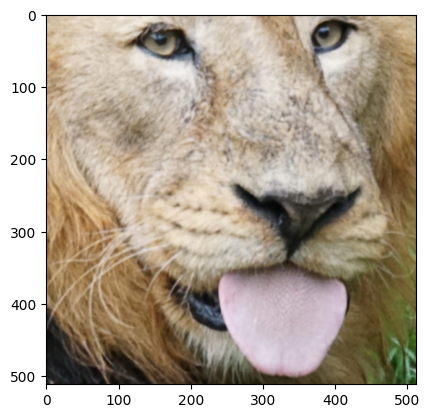

In [14]:
epochs = 2000
lr = 1e-3

optimizer = torch.optim.Adam(recon_net.parameters(), lr=lr)
loss_fn = torch.nn.functional.l1_loss

loss_list = []
best_loss = 0
best_model_state = None


for i in range(epochs):
    optimizer.zero_grad()

    generated = recon_net(fourier_mapped_x)

    loss = loss_fn(target_img, generated)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'{i} : loss {float(loss)}')
        loss_list.append(loss)
    
    # save best model state
    with torch.no_grad():
        loss = loss_fn(target_img, generated)
        if loss < best_loss or i == 0:
            best_loss = loss
            best_model_state = recon_net.state_dict()
        else:
            continue

# squeeze generated tensor because it has batch dimension.
tensor_img_show(generated.squeeze(0))

### E. Save best model state

In [15]:
best_model_state_name = f'recon_net_paper_ver_for_{IMG_NUM}.pth'
torch.save(best_model_state, best_model_state_name)

In [16]:
best_model = ReconNet(num_layers = 4, mapping_size = 2*GAUSSIAN_VEC_LEN)
best_model.load_state_dict(torch.load(best_model_state_name))
best_model.to(device)

ReconNet(
  (conv_block): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (last_layer): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
)

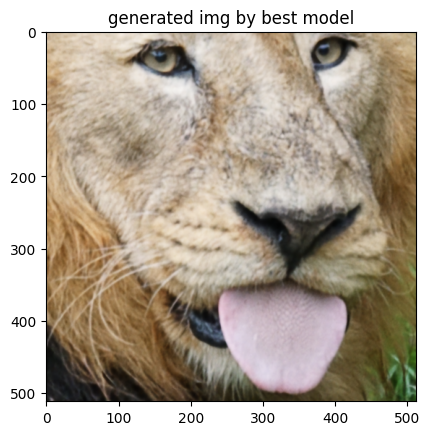

In [17]:
generated_img_by_best_model = best_model(fourier_mapped_x)

plt.title('generated img by best model')
tensor_img_show(generated_img_by_best_model.squeeze(0))

In [18]:
PSNR(generated_img_by_best_model.squeeze(0), train_y)

34.972232818603516